Data: 

A vehicle equipped with a top lidar, a GNSS-INS, and cameras is navigating through an urban environment. All sensors are intrinsically and extrinsically calibrated, time-synchronized, and supported by RTK correction data for GNSS accuracy. The collected sensor data is recorded and accessible for processing here. (Links to an external site.)

 

Tasks: 

1. Point Cloud Aggregation – 15 points 

Using the provided calibration and ego-motion data from GNSS-INS, aggregate frame-by-frame lidar point data to create a comprehensive virtual point cloud representation of the environment along the vehicle's trajectory. 
 

2. Moving Object Filtering – 15 points 

From the aggregated virtual point cloud, identify and remove data corresponding to moving objects to create a static representation of the environment. 
 

3. Point Cloud Colorization – 10 points 

Enhance the static virtual point cloud by assigning color values to the points using image data from the cameras. This will result in a visually enriched, realistic representation of the environment. 

In [2]:
!pip show open3d


Name: open3d
Version: 0.18.0
Summary: Open3D: A Modern Library for 3D Data Processing.
Home-page: https://www.open3d.org
Author: Open3D Team
Author-email: info@open3d.org
License: MIT
Location: /home/syma/Python-3.10.0/myenv/lib/python3.10/site-packages
Requires: addict, configargparse, dash, ipywidgets, matplotlib, nbformat, numpy, pandas, pillow, pyquaternion, pyyaml, scikit-learn, tqdm, werkzeug
Required-by: 


HERE

In [3]:
!pip install nuscenes-devkit open3d numpy scikit-learn opencv-python


In [2]:
from nuscenes.nuscenes import NuScenes

""" Initialize the nuScenes dataset object for the mini dataset version. 
# - `version`: Specifies the dataset version (`v1.0-mini` for the mini dataset).
# - `dataroot`: Path to the extracted dataset folder.
# - `verbose`: Set to `True` to enable detailed logging.
# Initialize nuScenes with the mini dataset 
"""
nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)


ModuleNotFoundError: No module named 'nuscenes'

In [2]:
nusc.scene

[{'token': 'cc8c0bf57f984915a77078b10eb33198',
  'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
  'nbr_samples': 39,
  'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
  'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
  'name': 'scene-0061',
  'description': 'Parked truck, construction, intersection, turn left, following a van'},
 {'token': 'fcbccedd61424f1b85dcbf8f897f9754',
  'log_token': '53cf9c55dd8644bea67b9f009fc1ee38',
  'nbr_samples': 40,
  'first_sample_token': '3e8750f331d7499e9b5123e9eb70f2e2',
  'last_sample_token': '281b92269fd648d4b52d06ac06ca6d65',
  'name': 'scene-0103',
  'description': 'Many peds right, wait for turning car, long bike rack left, cyclist'},
 {'token': '6f83169d067343658251f72e1dd17dbc',
  'log_token': '881dd2f8aaec49b681eb54be5bf3b3e2',
  'nbr_samples': 41,
  'first_sample_token': '8687ba92abd3406aa797115b874ebeba',
  'last_sample_token': 'dcbe451d383e450786aaad04ab9d3790',
  'name': 'scene-0553',
  'description': 'Wait at intersect

Point Cloud Aggregation 

Using the provided calibration and ego-motion data from GNSS-INS, aggregate frame-by-frame lidar point data to create a comprehensive virtual point cloud representation of the environment along the vehicle's trajectory. 

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.463 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


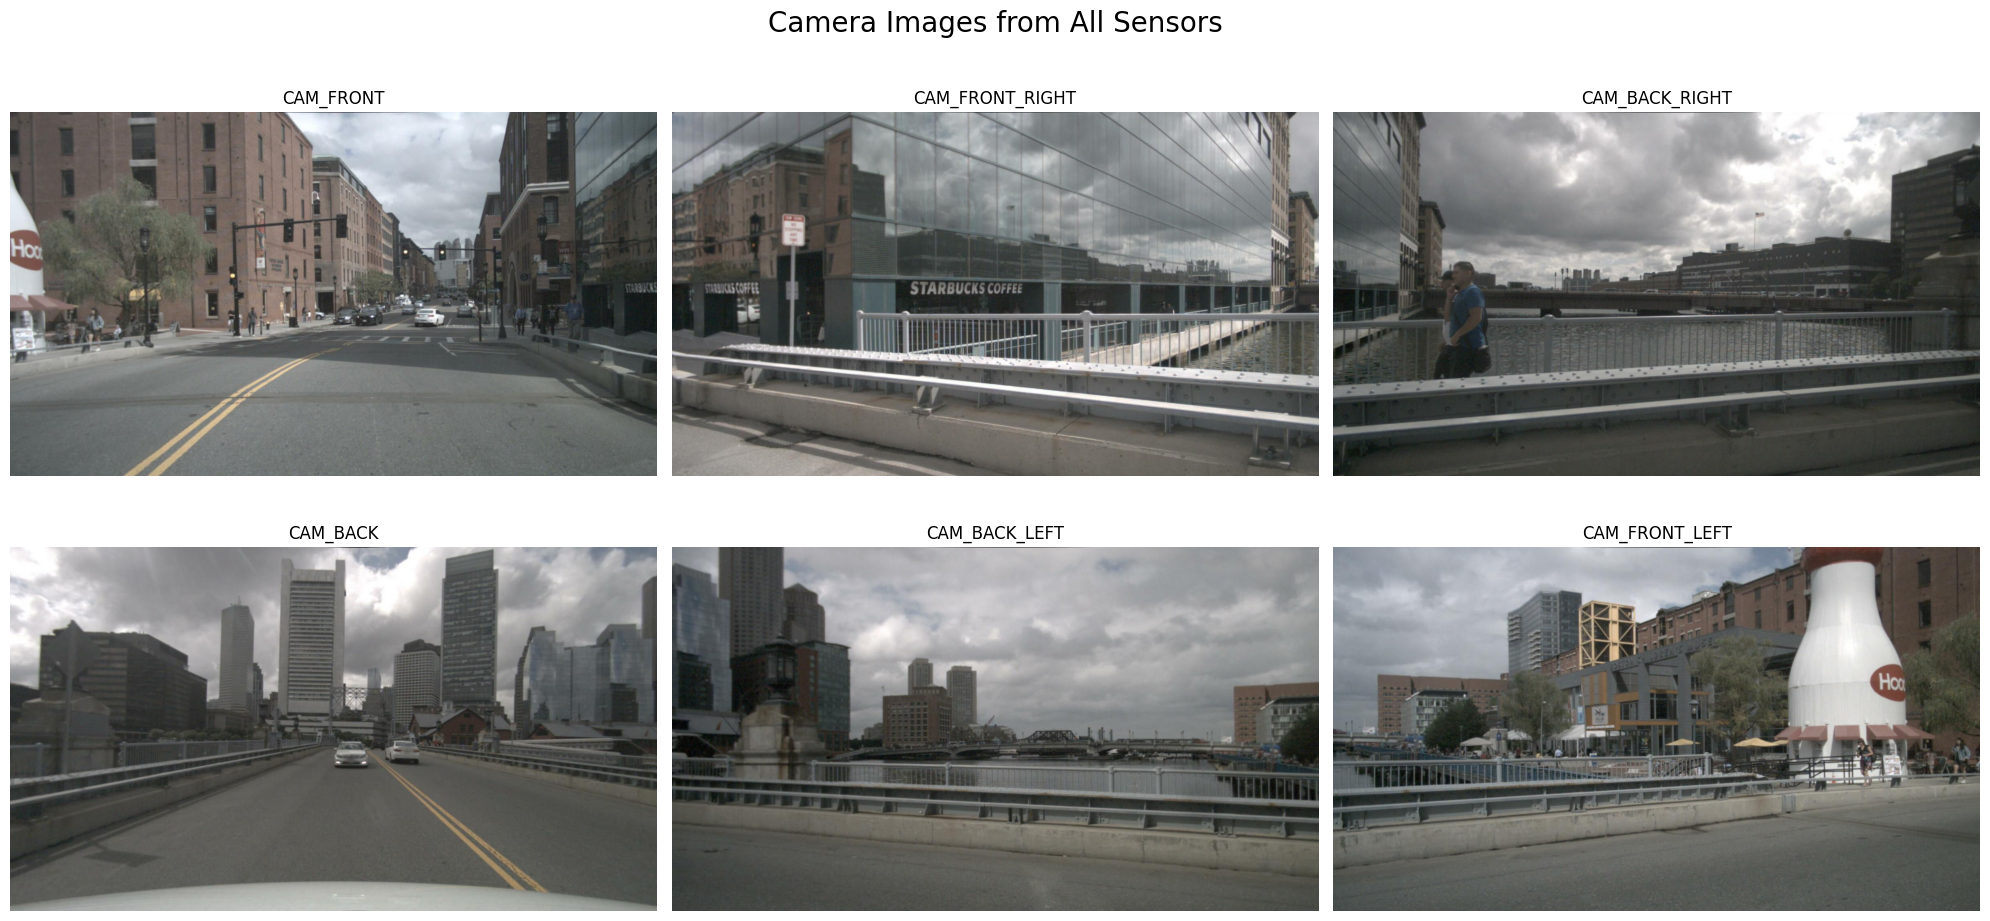

In [6]:
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes

def display_all_camera_images(nusc, sample_token):
    """
    Display images from all camera sensors for a given sample.

    Args:
        nusc (NuScenes): NuScenes object.
        sample_token (str): Sample token for the scene.

    Returns:
        None. Displays the images.
    """
    # Get the sample data
    sample = nusc.get("sample", sample_token)

    # Filter out camera data keys
    camera_channels = [key for key in sample['data'].keys() if "CAM" in key]

    # Plot all camera images
    plt.figure(figsize=(20, 10))
    for idx, camera_channel in enumerate(camera_channels):
        camera_token = sample['data'][camera_channel]
        camera_data = nusc.get("sample_data", camera_token)
        image_path = nusc.get_sample_data_path(camera_token)

        # Read and plot the image
        img = plt.imread(image_path)
        plt.subplot(2, 3, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(camera_channel)

    plt.suptitle("Camera Images from All Sensors", fontsize=20)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version="v1.0-mini", dataroot="Dataset/v1.0-mini", verbose=True)

    # Specify the scene name
    scene_name = "scene-0103"  # Replace with your desired scene name
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)

    # Display images from all cameras for the first sample in the scene
    display_all_camera_images(nusc, scene['first_sample_token'])


In [94]:
from nuscenes.nuscenes import NuScenes
from PIL import Image
import os

def combine_camera_images(nusc, sample_token, output_dir="combined_images", filename_prefix="sample"):
    """
    Combine images from all cameras into a single image for a given sample.

    Args:
        nusc (NuScenes): NuScenes object.
        sample_token (str): Sample token for the scene.
        output_dir (str): Directory to save the combined images.
        filename_prefix (str): Prefix for the combined image filenames.

    Returns:
        str: Path to the saved combined image.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the sample data
    sample = nusc.get("sample", sample_token)

    # Filter out camera data keys
    camera_channels = [key for key in sample['data'].keys() if "CAM" in key]

    # Load images for each camera
    images = []
    for camera_channel in camera_channels:
        camera_token = sample['data'][camera_channel]
        image_path = nusc.get_sample_data_path(camera_token)
        img = Image.open(image_path)
        images.append(img)

    # Determine layout for combined image (e.g., 2 rows x 3 columns)
    rows, cols = 2, 3
    img_width, img_height = images[0].size
    combined_width = cols * img_width
    combined_height = rows * img_height

    # Create a blank canvas for the combined image
    combined_image = Image.new("RGB", (combined_width, combined_height))

    # Paste individual camera images onto the canvas
    for idx, img in enumerate(images):
        x_offset = (idx % cols) * img_width
        y_offset = (idx // cols) * img_height
        combined_image.paste(img, (x_offset, y_offset))

    # Save the combined image
    output_path = os.path.join(output_dir, f"{filename_prefix}_{sample_token}.jpg")
    combined_image.save(output_path)
    return output_path

def process_scene_samples(nusc, scene_name, output_dir="combined_images"):
    """
    Process all samples in a scene to generate combined camera images.

    Args:
        nusc (NuScenes): NuScenes object.
        scene_name (str): Scene name to process.
        output_dir (str): Directory to save combined images.

    Returns:
        None.
    """
    # Find the specified scene
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)

    # Get the first sample token
    sample_token = scene['first_sample_token']

    print(f"Processing scene '{scene_name}'...")

    # Iterate through all samples in the scene
    while sample_token:
        print(f"Processing sample: {sample_token}")
        try:
            # Generate and save combined image
            combine_camera_images(nusc, sample_token, output_dir, filename_prefix=scene_name)
        except Exception as e:
            print(f"Failed to process sample {sample_token}: {e}")

        # Get the next sample token
        sample = nusc.get("sample", sample_token)
        sample_token = sample['next'] if sample['next'] != '' else None

    print(f"All samples in scene '{scene_name}' have been processed.")

if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version="v1.0-mini", dataroot="Dataset/v1.0-mini", verbose=True)

    # Specify the scene name
    scene_name = "scene-0103"  # Replace with your desired scene name

    # Process all samples in the scene
    process_scene_samples(nusc, scene_name)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.422 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Processing scene 'scene-0103'...
Processing sample: 3e8750f331d7499e9b5123e9eb70f2e2
Processing sample: 3950bd41f74548429c0f7700ff3d8269
Processing sample: c5f58c19249d4137ae063b0e9ecd8b8e
Processing sample: 700c1a25559b4433be532de3475e58a9
Processing sample: 747aa46b9a4641fe90db05d97db2acea
Processing sample: f4f86af4da3b49e79497deda5c5f223a
Processing sample: 6832e717621341568c759151b5974512
Processing sample: c59e60042a8643e899008da2e446acca
Processing sample: fa65a298c01f44e7a182bbf9e5fe3697
Processing sample: a98fba72bde9433fb882032d18aedb2e
Processing sample: b6b0d9f2f2e14a3aaa2c8aedeb1edb69
Processing sample: 796b1988dd254f74bf2fb19ba9c5b8c6
Processing sample: 0

#### <span style="color:red;"> Question 1:  Using the provided calibration and ego-motion data from GNSS-INS, aggregate frame-by-frame lidar point data to create a comprehensive virtual point cloud representation of the environment along the vehicle's trajectory. 


#### **<span style="color:cyan;">Goal</span>**
- **<span style="color:white;">Aggregate LiDAR data from multiple frames of a NuScenes scene into a globally aligned point cloud, providing a comprehensive representation of the environment for visualization and analysis.</span>**

---

#### **<span style="color:yellow;">Challenges</span>**

#### **<span style="color:red;">1. Alignment Across Frames:</span>**
- **<span style="color:white;">Each LiDAR frame is captured in the sensor's local coordinate system, requiring transformations to align all points in a common global coordinate frame.</span>**

#### **<span style="color:red;">2. Coordinate Transformations:</span>**
- **<span style="color:white;">Combining multiple transformations (sensor-to-ego and ego-to-global) without introducing errors or misalignments.</span>**



### **<span style="color:yellow;">Approach</span>**

---

#### **<span style="color:lime;">Step 1: Scene Initialization</span>**
#### **<span style="color:white;">Method</span>**:
- Identify the scene using its name (e.g., `"scene-0103"`) from the NuScenes dataset.
- Retrieve the **first sample token** to begin the frame-by-frame aggregation process.

#### **<span style="color:white;">Reasoning</span>**:
- Scenes in NuScenes are sequences of frames. Starting with the first sample ensures sequential processing of LiDAR data.

---

#### **<span style="color:lime;">Step 2: Loop Through Frames</span>**
#### **<span style="color:white;">Method</span>**:
- Iterate through all frames in the scene using the `sample['next']` token.
- For each frame:
  1. Retrieve the LiDAR data file path (`LIDAR_TOP`).
  2. Load the point cloud using `LidarPointCloud.from_file()`.

#### **<span style="color:white;">Reasoning</span>**:
- Sequentially processing frames ensures that all LiDAR data from the scene is included in the aggregated point cloud.

---

#### **<span style="color:lime;">Step 3: Coordinate Transformation</span>**
#### **<span style="color:white;">Method</span>**:
1. Retrieve **sensor calibration** data to transform the LiDAR data from the **sensor frame to the ego (vehicle) frame**:
   - Use the sensor's translation and rotation.
   - Compute the transformation matrix:  
     \[
     \text{From Sensor to Ego} = \text{Translation Matrix} \times \text{Rotation Quaternion}
     \]
2. Retrieve **ego pose** data to transform from the **ego frame to the global frame**:
   - Use the ego vehicle's position and orientation in the world.
   - Compute the transformation matrix:  
     \[
     \text{From Ego to Global} = \text{Translation Matrix} \times \text{Rotation Quaternion}
     \]
3. Combine both transformations to map points directly from the **sensor frame to the global frame**:
   \[
   \text{From Sensor to Global} = \text{From Ego to Global} \times \text{From Sensor to Ego}
   \]
4. Apply the transformation to the LiDAR point cloud using `.transform()`.

#### **<span style="color:white;">Reasoning</span>**:
- LiDAR sensors capture data in their local coordinate system. Transforming the points to the global frame ensures spatial alignment across frames.

---

#### **<span style="color:lime;">Step 4: Convert and Aggregate</span>**
#### **<span style="color:white;">Method</span>**:
1. Convert the transformed points to an Open3D `PointCloud` object.
2. Append the points to the **aggregated point cloud** initialized earlier.
3. Continue processing until all frames are aggregated.

#### **<span style="color:white;">Reasoning</span>**:
- Combining all points in the global frame results in a comprehensive representation of the entire scene.

---

#### **<span style="color:lime;">Step 5: Save and Visualize</span>**
#### **<span style="color:white;">Method</span>**:
1. Save the aggregated point cloud to a `.pcd` file using `o3d.io.write_point_cloud()`.
2. Visualize the point cloud with Open3D:
   - Customize visualization settings (e.g., point size, background color).

#### **<span style="color:white;">Reasoning</span>**:
- Saving enables further analysis or reuse in other workflows.
- Visualization provides a clear view of the aggregated scene for inspection.

---

#### **<span style="color:yellow;">Key Features</span>**
- **<span style="color:white;">Frame-by-Frame Aggregation</span>**: Sequentially processes all frames in a scene.
- **<span style="color:white;">Global Alignment</span>**: Aligns points in the world coordinate system.
- **<span style="color:white;">Efficient Visualization</span>**: Uses Open3D for flexible and interactive point cloud rendering.

---

#### **<span style="color:yellow;">Output</span>**
- **<span style="color:white;">Point Cloud File:</span>** `aggregated_cloud.pcd`
- **<span style="color:white;">Visualization:</span>** Displays the aggregated point cloud in a customized viewer.


In [1]:
import numpy as np
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix, Quaternion

def aggregate_point_clouds(nusc, scene_name):
    """
    Aggregate LiDAR data into a global point cloud for a given scene.
    """
    # Find the specified scene
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    sample_token = scene['first_sample_token']  # First sample in the scene
    aggregated_cloud = o3d.geometry.PointCloud()  # Initialize an empty point cloud
    # Loop through all samples in the scene
    while sample_token:  
        sample = nusc.get('sample', sample_token)  # Retrieve the current sample
        lidar_token = sample['data']['LIDAR_TOP']  # Get the LiDAR data token
        lidar_data = nusc.get('sample_data', lidar_token)  # Metadata for the LiDAR data
        lidar_file_path = nusc.get_sample_data_path(lidar_token)  # File path for the LiDAR data

        # Load the LiDAR point cloud
        pc = LidarPointCloud.from_file(lidar_file_path)

        # Get ego pose and sensor calibration
        ego_pose = nusc.get('ego_pose', lidar_data['ego_pose_token'])  # Global position of the ego vehicle
        sensor_calib = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])  # LiDAR sensor position

        # Create transformation: sensor frame -> car frame -> global frame
        from_sensor_to_ego = transform_matrix(sensor_calib['translation'], Quaternion(sensor_calib['rotation']), inverse=False)
        from_ego_to_global = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation']), inverse=False)
        from_sensor_to_global= from_ego_to_global @ from_sensor_to_ego  # Sensor frame to global frame transformation

        # Transform points to the global frame
        pc.transform(from_sensor_to_global)

        # Convert to Open3D point cloud
        lidar_o3d = o3d.geometry.PointCloud()
        lidar_o3d.points = o3d.utility.Vector3dVector(pc.points.T[:, :3])  # Use the first three columns (x, y, z)

        # Aggregate into one point cloud
        if len(lidar_o3d.points) > 0:  # Only add if there are points
            aggregated_cloud.points.extend(lidar_o3d.points)

        # Move to the next sample
        sample_token = sample['next'] if sample['next'] != '' else None

    return aggregated_cloud

if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)

    # Example Usage
    scene_name = "scene-0103"  # Replace with a valid scene name from the mini dataset
    aggregated_cloud = aggregate_point_clouds(nusc, scene_name)  # Aggregate point clouds

    # Save and visualize the aggregated point cloud
    print("Aggregated Cloud Points: ", len(aggregated_cloud.points))  # Print the total number of points
    o3d.io.write_point_cloud("aggregated_cloud.pcd", aggregated_cloud)  # Save as .pcd file

    # Load the saved point cloud
    pcd = o3d.io.read_point_cloud("aggregated_cloud.pcd")

    # Create a custom visualization window
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Aggregated Point Cloud")  # Set the window title

    # Customize visualization options
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])  # Black background
    opt.point_size = 0.8  # Adjust point size for better visualization

    # Add the point cloud to the visualization
    vis.add_geometry(pcd)

    # Run the visualizer
    vis.run()

    # Destroy the window after use
    vis.destroy_window()


ModuleNotFoundError: No module named 'open3d'

#### <span style="color:red;"> Question 2: From the aggregated virtual point cloud, identify and remove data corresponding to moving objects to create a static representation of the environment. 

### 🚗 **<span style="color:cyan;">Static Environment Extraction from Aggregated Point Cloud</span>**

---

### **<span style="color:yellow;">Goal</span>**
- **<span style="color:white;">From the aggregated virtual point cloud, identify and remove data corresponding to moving objects to create a static representation of the environment.</span>**

---

### **<span style="color:yellow;">Challenges</span>**
1. **<span style="color:red;">Ground Points:</span>** Ground points within bounding boxes may cause misclassification.
2. **<span style="color:red;">Bounding Box Overlap:</span>** Overlapping bounding boxes may lead to errors in distinguishing between static and moving objects.
3. **<span style="color:red;">Velocity Threshold Sensitivity:</span>** Slight movements may misclassify objects as moving.

---

### **<span style="color:lime;">Approach</span>**

---

### **<span style="color:white;">Step 1: Load Aggregated Point Cloud</span>**
- **<span style="color:lime;">Method:</span>**
  - Load `.pcd` file representing the aggregated point cloud using Open3D.
- **<span style="color:white;">Reasoning:</span>**
  - A consolidated point cloud captures the entire scene, including both static and moving objects.

---

### **<span style="color:white;">Step 2: Extract Annotations and Timestamps</span>**
- **<span style="color:lime;">Method:</span>**
  - Retrieve annotations and timestamps for the scene using the NuScenes API.
  - Sort the annotations and timestamps to ensure temporal consistency.
- **<span style="color:white;">Reasoning:</span>**
  - Temporal alignment is crucial for accurate velocity calculations and object tracking.

---

### **<span style="color:white;">Step 3: Filter Ground Points</span>**
- **<span style="color:lime;">Method:</span>**
  - Use a height threshold (\(z < 0.1\)) to exclude ground points.
- **<span style="color:white;">Reasoning:</span>**
  - Ground points can interfere with object classification.

---

### **<span style="color:white;">Step 4: Classify Static and Moving Points</span>**
#### **<span style="color:green;">Static Points:</span>**
- **<span style="color:lime;">Method:</span>**
  - Use bounding boxes labeled as `static_object.*` or `movable_object.*` to classify points as static.
- **<span style="color:white;">Reasoning:</span>**
  - These labels represent stationary objects like parked vehicles or traffic cones.

#### **<span style="color:red;">Moving Points:</span>**
- **<span style="color:lime;">Method:</span>**
  - Compute velocity using the change in translation over time:
    \[
    v = \frac{\|T_{\text{current}} - T_{\text{previous}}\|}{\Delta t}
    \]
  - Use velocity thresholds to classify points as moving.
  - Map each moving object’s points to its **instance token** for identification.
- **<span style="color:white;">Reasoning:</span>**
  - Velocity provides a reliable metric for identifying dynamic objects.
  - Object mapping enables detailed analysis and tracking of individual instances.

---

### **<span style="color:white;">Step 5: Visualization and Output</span>**
1. **<span style="color:green;">Static Cloud:</span>**
   - Assign **green** color for visualization of stationary objects.
2. **<span style="color:red;">Moving Cloud:</span>**
   - Assign **red** color for dynamic objects.
3. **<span style="color:yellow;">Combined Cloud:</span>**
   - Merge static and moving point clouds for a unified view.

---

### **<span style="color:lime;">Key Methods and Reasoning</span>**

| **<span style="color:white;">Method</span>**               | **<span style="color:white;">Reasoning</span>**                                                              |
|---------------------------|------------------------------------------------------------------------------------------|
| **Bounding Box Classification**   | Distinguishes between static and moving objects using NuScenes labels.                 |
| **Velocity Computation**          | Compute motion to differentiate between static and moving objects.                  |
| **Ground Filtering**              | Removes irrelevant ground points to enhance classification accuracy.                   |
| **Object Mapping**                | Links moving points to specific instance tokens for detailed tracking.                |
| **Color Coding**                  | Provides clear visual differentiation between static and moving objects.               |

---

### **<span style="color:lime;">Results</span>**

---

#### **<span style="color:green;">Static Cloud:</span>**
- **<span style="color:white;">Description:</span>**
  - Contains points identified as static using bounding boxes labeled `static_object.*` or `movable_object.*`.
  - Examples: Parked vehicles, buildings, traffic cones.
- **<span style="color:white;">Color:</span>**
  - Represented in **green** for visual clarity.

---

#### **<span style="color:red;">Moving Cloud:</span>**
- **<span style="color:white;">Description:</span>**
  - Contains points identified as moving using velocity thresholds and bounding boxes for dynamic objects.
  - Includes detailed **object mappings** to track specific instances.
  - Examples: Moving vehicles, pedestrians, cyclists.
- **<span style="color:white;">Color:</span>**
  - Represented in **red** for easy differentiation from static objects.

---

#### **<span style="color:yellow;">Combined Cloud:</span>**
- **<span style="color:white;">Description:</span>**
  - A unified visualization combining static and moving objects for comprehensive analysis.
- **<span style="color:white;">Output Files:</span>**
  - **`static_environment.pcd`**: Contains the filtered static point cloud.
  - **`moving_objects.pcd`**: Contains the filtered moving point cloud.
  - **`colored_combined_cloud.pcd`**: Merges both point clouds for visualization.

---

#### **<span style="color:lime;">Object Mapping Details</span>**
- **<span style="color:white;">Instance Mapping:</span>**
  - Each moving object is mapped to its **instance token**.
  
    ```
- **<span style="color:white;">Purpose:</span>**
  - Enables detailed analysis of moving objects in the scene.



In [ ]:
import numpy as np
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, Box
from nuscenes.utils.geometry_utils import points_in_box, Quaternion

def compute_velocity(previous_translation, current_translation, delta_time):
    """
    Compute velocity using change in translation and time.
    """

    ## Compute the Euclidean distance between two positions and divide by time difference to get velocity
    delta_distance = np.linalg.norm(np.array(current_translation) - np.array(previous_translation))
    return delta_distance / delta_time

def filter_moving_objects_from_aggregated(aggregated_cloud, sample_annotations, timestamps, velocity_threshold):
    """
    Filters moving objects from an aggregated point cloud using NuScenes annotations.
    """
    ## Convert the aggregated point cloud into a NumPy array
    aggregated_points = np.asarray(aggregated_cloud.points)
    # Initialize a mask for static points (all points assumed static initially)
    static_indices = np.ones(len(aggregated_points), dtype=bool)  
     # Initialize a mask for moving points (no points are moving initially
    moving_indices = np.zeros(len(aggregated_points), dtype=bool) 
    # Define a threshold for ground points based on height (z-axis)
    ground_threshold = 0.1
    # Create a mask to identify ground points
    ground_mask = aggregated_points[:, 2] < ground_threshold 
    # Initialize dictionaries to store previous translations and object mappings
    previous_translations = {}
    object_mapping = {}

    # Sort timestamps and annotations together to ensure temporal consistency
    timestamps, sample_annotations = zip(*sorted(zip(timestamps, sample_annotations)))

    # Loop through consecutive annotation frames
    for i in range(1, len(sample_annotations)):
        current_annotations = sample_annotations[i]
        ## Time difference between frames
        delta_time = timestamps[i] - timestamps[i - 1]

        for annotation in current_annotations:
            # Get category name and skip invalid annotations
            category_name = annotation['category_name']
            if 'translation' not in annotation or 'size' not in annotation or 'rotation' not in annotation:
                print(f"Invalid annotation data: {annotation}")
                continue
            # Extract instance token, translation, and size from the annotation
            instance_token = annotation['instance_token']
            current_translation = annotation['translation']
            size = annotation['size']
            # Skip annotations with missing or invalid data
            if not current_translation or not size or any(s <= 0 for s in size):
                continue

             # Handle static objects
            if category_name.startswith("static_object.") or category_name.startswith("movable_object."):
                # Create a bounding box for the static object
                bbox = Box(current_translation, size, Quaternion(annotation['rotation']))
                # Identify points within the bounding box
                mask = points_in_box(bbox, aggregated_points.T)
                # Mark points inside the static bounding box as non-static
                static_indices[mask] = False
                continue

            # Handle moving objects
            if instance_token in previous_translations:
                # Compute velocity for the current object
                previous_translation = previous_translations[instance_token]
                velocity = compute_velocity(previous_translation, current_translation, delta_time)
                # Create a bounding box for the moving object
                bbox = Box(current_translation, size, Quaternion(annotation['rotation']))
                # Identify points within the bounding box
                mask = points_in_box(bbox, aggregated_points.T)
                # Exclude ground points from moving points
                indices = np.where(mask & ~ground_mask)[0]

                if velocity > velocity_threshold:  # If the velocity exceeds the threshold, classify as moving
                    moving_indices[indices] = True
                    # Store the moving points for analysis
                    if instance_token not in object_mapping:
                        object_mapping[instance_token] = {
                            "category": category_name,
                            "points": aggregated_points[indices],
                        }
                    else:
                        object_mapping[instance_token]["points"] = np.vstack(
                            [object_mapping[instance_token]["points"], aggregated_points[indices]]
                        )
                else:
                    # If the velocity is below the threshold, classify as static
                    static_indices[indices] = False
            # Update the previous translation for the current object
            previous_translations[instance_token] = current_translation

    # Extract static and moving points using the masks
    static_points = aggregated_points[static_indices]
    moving_points = aggregated_points[moving_indices]

    # Create Open3D point clouds for static and moving points
    static_point_cloud = o3d.geometry.PointCloud()
    static_point_cloud.points = o3d.utility.Vector3dVector(static_points)
    static_point_cloud.paint_uniform_color([0, 1, 0])  # Green color for static objects

    moving_point_cloud = o3d.geometry.PointCloud()
    moving_point_cloud.points = o3d.utility.Vector3dVector(moving_points)
    moving_point_cloud.paint_uniform_color([1, 0, 0])  # Red color for moving objects

    # Print summary of the number of static and moving points
    print(f"Number of static points: {np.sum(static_indices)}, Moving points: {np.sum(moving_indices)}")

    return static_point_cloud, moving_point_cloud, object_mapping

if __name__ == "__main__":
    # Initialize NuScenes dataset
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)

    # Load the aggregated point cloud
    aggregated_cloud = o3d.io.read_point_cloud("aggregated_cloud.pcd")

    # Extract scene and annotations
    scene_name = "scene-0103"  # Replace with a valid scene name
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    sample_token = scene['first_sample_token']
    sample_annotations = []
    timestamps = []

    # Collect annotations and timestamps for the scene
    while sample_token:
        sample = nusc.get('sample', sample_token)
        if 'anns' not in sample or 'timestamp' not in sample:
            break

        # Append annotations and timestamps
        annotations = [nusc.get('sample_annotation', token) for token in sample['anns']]
        if annotations:
            sample_annotations.append(annotations)
            timestamps.append(sample['timestamp'] / 1e6)  # Convert to seconds
        sample_token = sample['next'] if sample['next'] else None

    # Set velocity threshold and filter moving objects
    velocity_threshold = 0.25
    static_cloud, moving_cloud, moving_objects = filter_moving_objects_from_aggregated(
        aggregated_cloud, sample_annotations, timestamps, velocity_threshold
    )
 
    # Save static and moving clouds
    o3d.io.write_point_cloud("static_environment.pcd", static_cloud)
    o3d.io.write_point_cloud("moving_objects.pcd", moving_cloud)

    # Visualize the combined point cloud
    combined_cloud = static_cloud + moving_cloud
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Static Aggregated Point Cloud with Moving Objects")
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])  # Set black background
    opt.point_size = 1.0  # Adjust point size

    vis.add_geometry(combined_cloud)
    vis.run()
    vis.destroy_window()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.474 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Number of static points: 1316191, Moving points: 171331


In [78]:
import json
import numpy as np
from PIL import Image
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix, Quaternion


def enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channels):
    """
    Assign RGB colors from multiple camera images to the static point cloud.

    Args:
        static_cloud (o3d.geometry.PointCloud): Static point cloud.
        nusc (NuScenes): NuScenes dataset object.
        sample_token (str): Token of the sample to process.
        camera_channels (list): List of camera channels to use for coloring.

    Returns:
        o3d.geometry.PointCloud: Static point cloud enriched with colors.
    """
    points = np.asarray(static_cloud.points)
    combined_colors = np.zeros((points.shape[0], 3))  # Initialize colors as black
    valid_point_counts = np.zeros(points.shape[0])  # To average colors across multiple cameras

    for camera_channel in camera_channels:
        print(f"Processing camera: {camera_channel}")
        
        # Get the camera sample data
        sample = nusc.get("sample", sample_token)
        cam_data = nusc.get("sample_data", sample["data"][camera_channel])
        cam_calib = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])
        cam_pose = nusc.get("ego_pose", cam_data["ego_pose_token"])

        # Load the camera image
        img_path = nusc.get_sample_data_path(cam_data["token"])
        image = np.asarray(Image.open(img_path))
        image_height, image_width = image.shape[:2]

        # Transformation matrices
        intrinsic = np.array(cam_calib["camera_intrinsic"])
        from_cam_to_ego = transform_matrix(cam_calib["translation"], Quaternion(cam_calib["rotation"]), inverse=False)
        from_ego_to_world = transform_matrix(cam_pose["translation"], Quaternion(cam_pose["rotation"]), inverse=False)
        from_cam_to_world = from_ego_to_world @ from_cam_to_ego
        from_world_to_camera = np.linalg.inv(from_cam_to_world)

        # Project points to camera frame
        points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))  # Add homogeneous coordinate
        points_in_camera_frame = (from_world_to_camera @ points_homogeneous.T).T

        # Normalize by depth
        depth = points_in_camera_frame[:, 2]
        points_2d = (intrinsic @ points_in_camera_frame[:, :3].T).T
        points_2d[:, 0] /= depth
        points_2d[:, 1] /= depth

        # Filter valid points
        valid_mask = (depth > 0) & \
                     (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) & \
                     (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height)

        valid_points_2d = points_2d[valid_mask]
        if valid_points_2d.shape[0] > 0:
            image_colors = image[valid_points_2d[:, 1].astype(int), valid_points_2d[:, 0].astype(int)]
            combined_colors[valid_mask] += image_colors / 255.0
            valid_point_counts[valid_mask] += 1

    # Average the colors for points visible in multiple cameras
    valid_point_counts[valid_point_counts == 0] = 1  # To avoid division by zero
    combined_colors /= valid_point_counts[:, None]
    static_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

    return static_cloud


def assign_gray_to_moving_cloud(moving_cloud):
    """
    Assign a grayscale color to all points in the moving cloud.

    Args:
        moving_cloud (o3d.geometry.PointCloud): Moving point cloud.

    Returns:
        o3d.geometry.PointCloud: Grayscale-colored moving cloud.
    """
    colors = np.full((len(moving_cloud.points), 3), 0.5)  # Gray color
    moving_cloud.colors = o3d.utility.Vector3dVector(colors)
    return moving_cloud


if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)
    camera_channel = ["CAM_FRONT"]

    # Load static and moving point clouds
    static_cloud = o3d.io.read_point_cloud("static_environment.pcd")
    moving_cloud = o3d.io.read_point_cloud("moving_objects.pcd")

    # Prepare annotations and timestamps
    scene_name = "scene-0103"  # Replace with a valid scene name
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    sample_token = scene['first_sample_token']

    # Enrich the static point cloud with camera image colors
    enriched_static_cloud = enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channel)

    # Assign gray color to the moving point cloud
    gray_moving_cloud = assign_gray_to_moving_cloud(moving_cloud)

    # Combine the two clouds
    combined_cloud = enriched_static_cloud + gray_moving_cloud

    # Save and visualize the combined point cloud
    o3d.io.write_point_cloud("colored_combined_cloud.pcd", combined_cloud)

    # Visualize the combined point cloud
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Colored Combined Point Cloud")
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])
    opt.point_size = 1.0  # Adjust point size for better visualization
    vis.add_geometry(combined_cloud)
    vis.run()
    vis.destroy_window()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.371 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Processing camera: CAM_FRONT


#### <span style="color:red;"> Question 3: Enhance the static virtual point cloud by assigning color values to the points using image data from the cameras. This will result in a visually enriched, realistic representation of the environment. 

### 📷  <span style="color:blue;">**LiDAR Point Cloud Enhancement with RGB Colors**</span>

---

### <span style="color:red;">**Goal**</span>  
<span style="color:yellow;">Enhance a static virtual point cloud by assigning realistic RGB colors from camera images, creating a visually enriched representation of the environment.</span>

---

### <span style="color:maroon;">**Challenges**</span>  
- <span style="color:yellow;">Map 3D points from the LiDAR frame to 2D pixel coordinates in the camera frame, ensuring only valid points are colorized.</span>


---

### <span style="color:green;">**Approach**</span>  

#### <span style="color:purple;">**Step 1: Load Point Clouds**</span>  
- <span style="color:white;">Load and separate the static and moving point clouds from `.pcd` files.</span>  

#### <span style="color:purple;">**Step 2: Enrich Static Cloud**</span>  
- <span style="color:white;">For each sample in a scene, enhance the static point cloud with RGB values extracted from camera images for all specified camera channels.</span>  

#### <span style="color:purple;">**Step 3: Grayscale Moving Cloud**</span>  
- <span style="color:white;">Assign grayscale color to the moving point cloud for contrast.</span>  

#### <span style="color:purple;">**Step 4: Combine and Visualize**</span>  
- <span style="color:white;">Combine the enriched static cloud and gray moving cloud into a single point cloud for visualization.</span>

---

### <span style="color:orange;">**Methods and Reasoning**</span>  

#### <span style="color:green;">**Extracting 3D Points**</span>  
- **Method:**  
  <span style="color:white;">Use `np.asarray(static_cloud.points)` to convert the point cloud into a NumPy array.</span>  
- **Reasoning:**  
  <span style="color:white;">NumPy arrays enable efficient numerical operations and transformations on 3D points.</span>  

---

#### <span style="color:yellow;">**Camera Data and Transformations**</span>  

##### <span style="color:green;">**Extract Camera Parameters**</span>  
- <span style="color:white;">**Intrinsic Matrix:** Projects 3D points onto a 2D image plane.</span>  
- <span style="color:white;">**Extrinsic Matrix:** Transforms points from the camera frame to the ego (vehicle) frame.</span>  

##### <span style="color:green;">**Transformation Flow**</span>  
- <span style="color:white;">Transform points from the world frame to the ego (vehicle) frame, and then to the camera frame.</span>  
- **Reasoning:**  
  <span style="color:white;">Aligning 3D points with the camera frame ensures accurate projection onto the image.</span>  

---

#### <span style="color:yellow;">**Projecting 3D Points to 2D**</span>  
- **Method:**  
  - <span style="color:white;">Convert 3D points to homogeneous coordinates.</span>  
  - <span style="color:white;">Apply transformations to map world coordinates to camera coordinates.</span>  
  - <span style="color:white;">Normalize using depth (z-coordinate) to get 2D pixel coordinates.</span>  

- **Reasoning:**  
  <span style="color:white;">The 2D projection maps 3D points to corresponding camera image pixels.</span>  

---

#### <span style="color:yellow;">**Filtering Valid Points**</span>  
- **Method:**  
  - <span style="color:white;">Filter points with:</span>  
    - <span style="color:white;">Positive depth (in front of the camera).</span>  
    - <span style="color:white;">Pixel coordinates within image bounds.</span>  

- **Reasoning:**  
  <span style="color:white;">Ensures only visible and valid points are colorized.</span>  

---

#### <span style="color:yellow;">**Grayscale for Moving Cloud**</span>  
- **Method:**  
  <span style="color:white;">Assign a uniform gray color (e.g., RGB = `[0.5, 0.5, 0.5]`) to all points in the moving cloud.</span>  

- **Reasoning:**  
  <span style="color:white;">Differentiates moving objects visually from the static environment.</span>  

---

#### <span style="color:yellow;">**Combining Clouds**</span>  
- **Method:**  
  <span style="color:white;">Combine the enriched static cloud and gray moving cloud into a single point cloud.</span>  

- **Reasoning:**  
  <span style="color:white;">Provides a unified view for visualization and analysis.</span>

---

### <span style="color:yellow;">**Results**</span>  
- **Static Points:**  
  <span style="color:white;">Enriched with RGB colors from camera images, providing realistic visualization.</span>  
- **Moving Points:**  
  <span style="color:white;">Assigned uniform grayscale for clear differentiation.</span>  
- **Combined Cloud:**  
  <span style="color:white;">Unified and visually enriched representation of the environment.</span>


In [ ]:
import json
import numpy as np
from PIL import Image
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix, Quaternion


def enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channels):
    """
    Assign RGB colors from multiple camera images to the static point cloud.

    Args:
        static_cloud (o3d.geometry.PointCloud): Static point cloud.
        nusc (NuScenes): NuScenes dataset object.
        sample_token (str): Token of the sample to process.
        camera_channels (list): List of camera channels to use for coloring.

    Returns:
        o3d.geometry.PointCloud: Static point cloud enriched with colors.
    """

    #Extract the 3D points from the static_cloud point cloud object into a NumPy array.
    points = np.asarray(static_cloud.points)


    #Create an array to store RGB color values for each point, initialized to black
    combined_colors = np.zeros((points.shape[0], 3))  

    #Initialize a counter for the number of cameras that can see each point.
    valid_point_counts = np.zeros(points.shape[0])  

   #Iterate over all specified camera channels
    for camera_channel in camera_channels:
        print(f"Processing camera: {camera_channel}")
        
        #Retrieve the NuScenes sample corresponding to the sample_token.
        sample = nusc.get("sample", sample_token)
        #Retrieve metadata for the specified camera channel.
        cam_data = nusc.get("sample_data", sample["data"][camera_channel])
        #Retrieve the calibrated sensor data for the camera.
        cam_calib = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])
        #Retrieve the ego pose data for the camera.
        cam_pose = nusc.get("ego_pose", cam_data["ego_pose_token"])

        # Load the camera image
        img_path = nusc.get_sample_data_path(cam_data["token"])
        image = np.asarray(Image.open(img_path))
        #Extract the image dimensions (height and width).
        image_height, image_width = image.shape[:2]

        """Transformation matrices"""
        intrinsic = np.array(cam_calib["camera_intrinsic"])
        #Compute the transformation matrix from the camera frame to the ego (vehicle) frame.
        from_cam_to_ego = transform_matrix(cam_calib["translation"], Quaternion(cam_calib["rotation"]), inverse=False)
        #Compute the transformation matrix from the ego frame to the world frame.
        from_ego_to_world = transform_matrix(cam_pose["translation"], Quaternion(cam_pose["rotation"]), inverse=False)
        #Compute the transformation matrix from the camera frame to the world frame.
        from_cam_to_world = from_ego_to_world @ from_cam_to_ego
    
        #Compute the inverse to transform points from the world frame to the camera frame.
        from_world_to_camera = np.linalg.inv(from_cam_to_world)

        # Project points to camera frame
        #Convert 3D points to homogeneous coordinates 
        points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1)))) 
        #Transform the points from the world frame to the camera frame.
        points_in_camera_frame = (from_world_to_camera @ points_homogeneous.T).T

        # Normalize by depth
        #Get the depth of the points in the camera frame.
        depth = points_in_camera_frame[:, 2]
        #Intrinsic matrix to project the 3D points into 2D image coordinates.
        points_2d = (intrinsic @ points_in_camera_frame[:, :3].T).T

        #Normalize the 2D points by the depth to get the pixel coordinates.
        points_2d[:, 0] /= depth
        points_2d[:, 1] /= depth

        """ Create a mask for points that have positive depth and are within the image bounds."""
        valid_mask = (depth > 0) & \
                     (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) & \
                     (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height)

        valid_points_2d = points_2d[valid_mask]
        # Retrieve the colors from the image for the valid projected points
        if valid_points_2d.shape[0] > 0:
            image_colors = image[valid_points_2d[:, 1].astype(int), valid_points_2d[:, 0].astype(int)]
            #Add the normalized colors to the combined_colors array.
            combined_colors[valid_mask] += image_colors / 255.0
            valid_point_counts[valid_mask] += 1

     # Set the colors in the static_cloud object.
    static_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

    return static_cloud

def assign_gray_to_moving_cloud(moving_cloud):
    """
    Assign a grayscale color to all points in the moving cloud.

    Args:
        moving_cloud (o3d.geometry.PointCloud): Moving point cloud.

    Returns:
        o3d.geometry.PointCloud: Grayscale-colored moving cloud.
    """
    colors = np.full((len(moving_cloud.points), 3), 0.5)  # Gray color
    moving_cloud.colors = o3d.utility.Vector3dVector(colors)
    return moving_cloud

if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)

    # Load static and moving point clouds
    static_cloud = o3d.io.read_point_cloud("static_environment.pcd")
    moving_cloud = o3d.io.read_point_cloud("moving_objects.pcd")

    # Retrieve the specific scene from the NuScenes dataset using its name.
    scene_name = "scene-0103"  
   
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    # Get the token of the first sample in the selected scene.
    sample_token = scene['first_sample_token']

    # Loop through all samples in the scene using the sample token.
    while sample_token:
        sample = nusc.get("sample", sample_token)
        camera_channels = [key for key in sample['data'].keys() if "CAM" in key]

        # Enhance the static point cloud by assigning RGB colors from camera images for the current sample.
        enriched_static_cloud = enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token,camera_channels)

        # Move to the next sample token
        sample_token = sample["next"] if sample["next"] else None

    # Assign gray color to the moving point cloud
    gray_moving_cloud = assign_gray_to_moving_cloud(moving_cloud)

    # Merge the enhanced static and moving point clouds into a single point cloud.
    combined_cloud = enriched_static_cloud + gray_moving_cloud

    # Save and visualize the combined point cloud
    o3d.io.write_point_cloud("colored_combined_cloud.pcd", combined_cloud)

    # Visualize the combined point cloud
    vis = o3d.visualization.Visualizer()

    vis.create_window(window_name="Enhance the colored static virtual point cloud  Cloud from the camera images")
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])
    opt.point_size = 1.0  # etter visualization
    #Add the combined point cloud to the visualizer
    vis.add_geometry(combined_cloud)
    vis.run()
    vis.destroy_window()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.430 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Processing camera: CAM_FRONT
Processing camera: CAM_FRONT_RIGHT
Processing camera: CAM_BACK_RIGHT
Processing camera: CAM_BACK
Processing camera: CAM_BACK_LEFT
Processing camera: CAM_FRONT_LEFT
Processing camera: CAM_FRONT
Processing camera: CAM_FRONT_RIGHT
Processing camera: CAM_BACK_RIGHT
Processing camera: CAM_BACK
Processing camera: CAM_BACK_LEFT
Processing camera: CAM_FRONT_LEFT
Processing camera: CAM_FRONT
Processing camera: CAM_FRONT_RIGHT
Processing camera: CAM_BACK_RIGHT
Processing camera: CAM_B

In [9]:
import json
import numpy as np
from PIL import Image
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix, Quaternion


def enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channels):
    """
    Assign RGB colors from multiple camera images to the static point cloud.

    Args:
        static_cloud (o3d.geometry.PointCloud): Static point cloud.
        nusc (NuScenes): NuScenes dataset object.
        sample_token (str): Token of the sample to process.
        camera_channels (list): List of camera channels to use for coloring.

    Returns:
        o3d.geometry.PointCloud: Static point cloud enriched with colors.
    """
    points = np.asarray(static_cloud.points)
    combined_colors = np.zeros((points.shape[0], 3))  # Initialize colors as black
    valid_point_counts = np.zeros(points.shape[0])  # To average colors across multiple cameras

  
   
    for camera_channel in camera_channels:
        print(f"Processing camera: {camera_channel}")
        # Get the camera sample data
        sample = nusc.get("sample", sample_token)
        cam_data = nusc.get("sample_data", sample["data"][camera_channel])
        cam_calib = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])
        cam_pose = nusc.get("ego_pose", cam_data["ego_pose_token"])

        # Load the camera image
        img_path = nusc.get_sample_data_path(cam_data["token"])
        image = np.asarray(Image.open(img_path))
        image_height, image_width = image.shape[:2]

        # Transformation matrices
        intrinsic = np.array(cam_calib["camera_intrinsic"])
        from_cam_to_ego = transform_matrix(cam_calib["translation"], Quaternion(cam_calib["rotation"]), inverse=False)
        from_ego_to_world = transform_matrix(cam_pose["translation"], Quaternion(cam_pose["rotation"]), inverse=False)
        from_cam_to_world = from_ego_to_world @ from_cam_to_ego
        from_world_to_camera = np.linalg.inv(from_cam_to_world)

        # Project points to camera frame
        points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))  # Add homogeneous coordinate
        points_in_camera_frame = (from_world_to_camera @ points_homogeneous.T).T

        # Normalize by depth
        depth = points_in_camera_frame[:, 2]
        points_2d = (intrinsic @ points_in_camera_frame[:, :3].T).T
        points_2d[:, 0] /= depth
        points_2d[:, 1] /= depth

        # Filter valid points
        valid_mask = (depth > 0) & \
                        (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) & \
                        (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height)

        valid_points_2d = points_2d[valid_mask]
        if valid_points_2d.shape[0] > 0:
            image_colors = image[valid_points_2d[:, 1].astype(int), valid_points_2d[:, 0].astype(int)]
            combined_colors[valid_mask] += image_colors / 255.0
            valid_point_counts[valid_mask] += 1

    # Average the colors for points visible in multiple cameras
    valid_point_counts[valid_point_counts == 0] = 1  # To avoid division by zero
    combined_colors /= valid_point_counts[:, None]
    static_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

    return static_cloud


def assign_gray_to_moving_cloud(moving_cloud):
    """
    Assign a grayscale color to all points in the moving cloud.

    Args:
        moving_cloud (o3d.geometry.PointCloud): Moving point cloud.

    Returns:
        o3d.geometry.PointCloud: Grayscale-colored moving cloud.
    """
    colors = np.full((len(moving_cloud.points), 3), 0.5)  # Gray color
    moving_cloud.colors = o3d.utility.Vector3dVector(colors)
    return moving_cloud


if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)
    # camera_channel = "CAM_FRONT"

    # Load static and moving point clouds
    static_cloud = o3d.io.read_point_cloud("static_environment.pcd")
    moving_cloud = o3d.io.read_point_cloud("moving_objects.pcd")

    # Prepare annotations and timestamps
    scene_name = "scene-0103"  # Replace with a valid scene name
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    sample_token = scene['first_sample_token']
    sample = nusc.get("sample", sample_token)
    camera_channel= [key for key in sample['data'].keys() if "CAM" in key]

    # Enrich the static point cloud with camera image colors
    enriched_static_cloud = enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channel)

    # Assign gray color to the moving point cloud
    gray_moving_cloud = assign_gray_to_moving_cloud(moving_cloud)

    # Combine the two clouds
    combined_cloud = enriched_static_cloud + gray_moving_cloud

    # Save and visualize the combined point cloud
    o3d.io.write_point_cloud("CAM_FRONT_colored_combined_cloud.pcd", combined_cloud)

    # Visualize the combined point cloud
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="CAM_FRONT_Colored Combined Point Cloud")
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])
    opt.point_size = 1.0  # Adjust point size for better visualization
    vis.add_geometry(combined_cloud)
    vis.run()
    vis.destroy_window()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.536 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Processing camera: CAM_FRONT
Processing camera: CAM_FRONT_RIGHT
Processing camera: CAM_BACK_RIGHT
Processing camera: CAM_BACK
Processing camera: CAM_BACK_LEFT
Processing camera: CAM_FRONT_LEFT


#### Compare FRONT Camera Image with Enhanced Point Cloud

In [1]:
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes

def display_camera_images(nusc, sample_token):
    """
    Display images from all camera sensors for a given sample.

    Args:
        nusc (NuScenes): NuScenes object.
        sample_token (str): Sample token for the scene.

    Returns:
        None. Displays the images.
    """
    # Get the sample data
    sample = nusc.get("sample", sample_token)

    # Filter out camera data keys
    camera_channels = ["CAM_FRONT"]

    # Plot all camera images
    plt.figure(figsize=(20, 10))
    for idx, camera_channel in enumerate(camera_channels):
        camera_token = sample['data'][camera_channel]
        camera_data = nusc.get("sample_data", camera_token)
        image_path = nusc.get_sample_data_path(camera_token)

        # Read and plot the image
        img = plt.imread(image_path)
       
        plt.imshow(img)
        plt.axis('off')
      

    plt.title("Camera Image from CAM_FRONT Sensor", fontsize=20)
    plt.tight_layout()
    plt.show()




In [8]:
import json
import numpy as np
from PIL import Image
import open3d as o3d
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix, Quaternion


def enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channels):
    """
    Assign RGB colors from multiple camera images to the static point cloud.

    Args:
        static_cloud (o3d.geometry.PointCloud): Static point cloud.
        nusc (NuScenes): NuScenes dataset object.
        sample_token (str): Token of the sample to process.
        camera_channels (list): List of camera channels to use for coloring.

    Returns:
        o3d.geometry.PointCloud: Static point cloud enriched with colors.
    """
    points = np.asarray(static_cloud.points)
    combined_colors = np.zeros((points.shape[0], 3))  # Initialize colors as black
    valid_point_counts = np.zeros(points.shape[0])  # To average colors across multiple cameras

  
    print(f"Processing camera: {camera_channel}")
    
    # Get the camera sample data
    sample = nusc.get("sample", sample_token)
    cam_data = nusc.get("sample_data", sample["data"][camera_channel])
    cam_calib = nusc.get("calibrated_sensor", cam_data["calibrated_sensor_token"])
    cam_pose = nusc.get("ego_pose", cam_data["ego_pose_token"])

    # Load the camera image
    img_path = nusc.get_sample_data_path(cam_data["token"])
    image = np.asarray(Image.open(img_path))
    image_height, image_width = image.shape[:2]

    # Transformation matrices
    intrinsic = np.array(cam_calib["camera_intrinsic"])
    from_cam_to_ego = transform_matrix(cam_calib["translation"], Quaternion(cam_calib["rotation"]), inverse=False)
    from_ego_to_world = transform_matrix(cam_pose["translation"], Quaternion(cam_pose["rotation"]), inverse=False)
    from_cam_to_world = from_ego_to_world @ from_cam_to_ego
    from_world_to_camera = np.linalg.inv(from_cam_to_world)

    # Project points to camera frame
    points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))  # Add homogeneous coordinate
    points_in_camera_frame = (from_world_to_camera @ points_homogeneous.T).T

    # Normalize by depth
    depth = points_in_camera_frame[:, 2]
    points_2d = (intrinsic @ points_in_camera_frame[:, :3].T).T
    points_2d[:, 0] /= depth
    points_2d[:, 1] /= depth

    # Filter valid points
    valid_mask = (depth > 0) & \
                    (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) & \
                    (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height)

    valid_points_2d = points_2d[valid_mask]
    if valid_points_2d.shape[0] > 0:
        image_colors = image[valid_points_2d[:, 1].astype(int), valid_points_2d[:, 0].astype(int)]
        combined_colors[valid_mask] += image_colors / 255.0
        valid_point_counts[valid_mask] += 1

    # Average the colors for points visible in multiple cameras
    valid_point_counts[valid_point_counts == 0] = 1  # To avoid division by zero
    combined_colors /= valid_point_counts[:, None]
    static_cloud.colors = o3d.utility.Vector3dVector(combined_colors)

    return static_cloud


def assign_gray_to_moving_cloud(moving_cloud):
    """
    Assign a grayscale color to all points in the moving cloud.

    Args:
        moving_cloud (o3d.geometry.PointCloud): Moving point cloud.

    Returns:
        o3d.geometry.PointCloud: Grayscale-colored moving cloud.
    """
    colors = np.full((len(moving_cloud.points), 3), 0.5)  # Gray color
    moving_cloud.colors = o3d.utility.Vector3dVector(colors)
    return moving_cloud


if __name__ == "__main__":
    # Initialize NuScenes
    nusc = NuScenes(version='v1.0-mini', dataroot='Dataset/v1.0-mini', verbose=True)
    camera_channel = "CAM_FRONT"

    # Load static and moving point clouds
    static_cloud = o3d.io.read_point_cloud("static_environment.pcd")
    moving_cloud = o3d.io.read_point_cloud("moving_objects.pcd")

    # Prepare annotations and timestamps
    scene_name = "scene-0103"  # Replace with a valid scene name
    scene = next(scene for scene in nusc.scene if scene['name'] == scene_name)
    sample_token = scene['first_sample_token']

    # Enrich the static point cloud with camera image colors
    enriched_static_cloud = enrich_static_cloud_with_colors_all_cameras(static_cloud, nusc, sample_token, camera_channel)

    # Assign gray color to the moving point cloud
    gray_moving_cloud = assign_gray_to_moving_cloud(moving_cloud)

    # Combine the two clouds
    combined_cloud = enriched_static_cloud + gray_moving_cloud

    # Save and visualize the combined point cloud
    o3d.io.write_point_cloud("CAM_FRONT_colored_combined_cloud.pcd", combined_cloud)

    # Visualize the combined point cloud
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="CAM_FRONT_Colored Combined Point Cloud")
    opt = vis.get_render_option()
    opt.background_color = np.array([0, 0, 0])
    opt.point_size = 1.0  # Adjust point size for better visualization
    vis.add_geometry(combined_cloud)
    vis.run()
    vis.destroy_window()


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.366 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Processing camera: CAM_FRONT


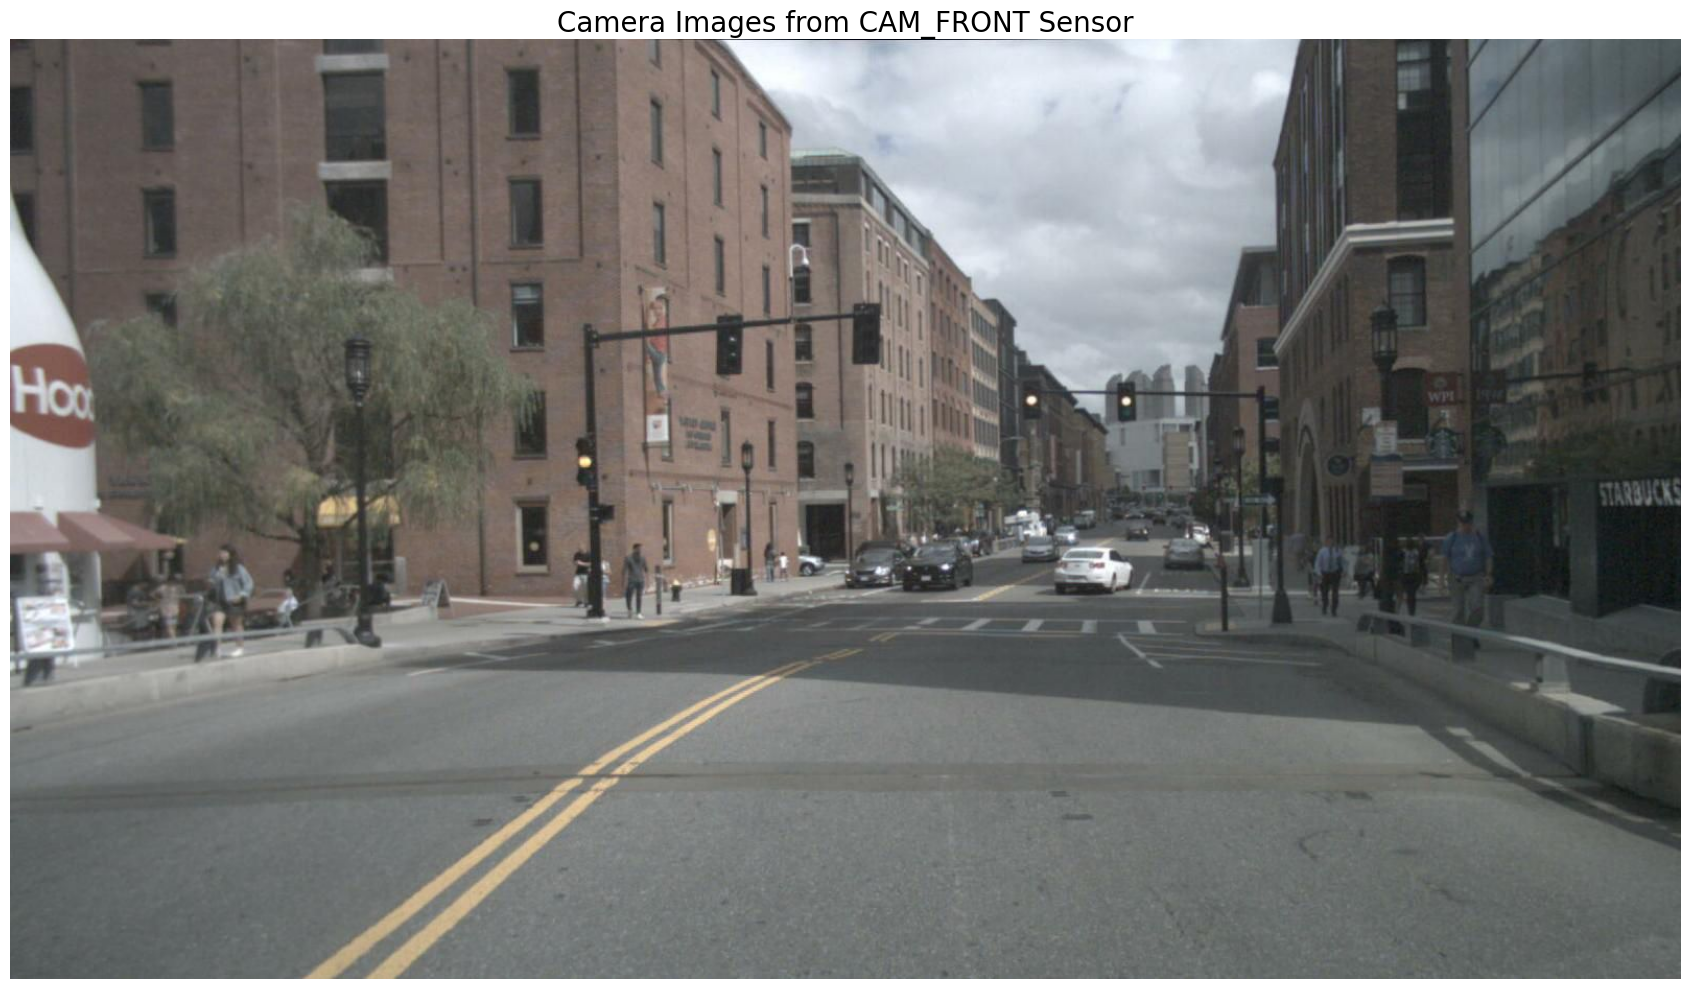

In [32]:
display_camera_images(nusc, scene['first_sample_token'])
